## Fun with Gene Vectors
- [Word Vector Experimentation](#2d)
- [Clustering Evaluation](#cluster)
- [Visual clustering on subset of filtered genes](#subset)
- [Image evaluation](#image)

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import tools
from tools.config import TCGA, GENE2VEC
from tools.utils import *
from tools.gene2vec import *
from tools.cluster import *
from tools.somatic import *

---
#### Word Vector Experimentation
<a id="2d"></a>

For each sample, now want to encode gene2vec embeddings as a prior on mutation data.
- Evaluate separation difference between gene2vec training iterations (checkpoints) (iter_1, iter_5, iter_10)
- Evaluate separation with dimension (16, 128, 1024)
- Evaluate Scree plot (break down of PC's) across dimensions

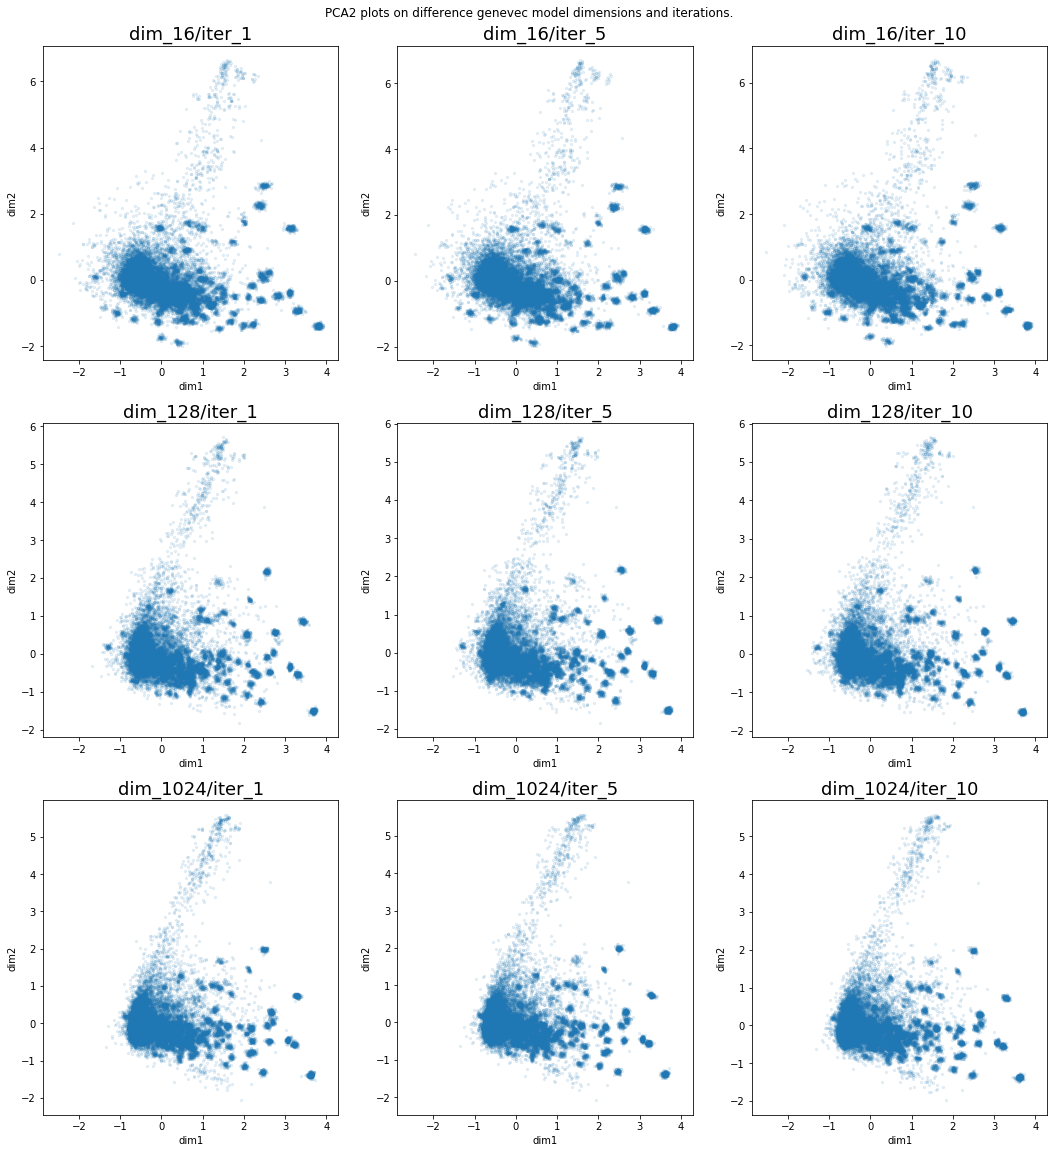

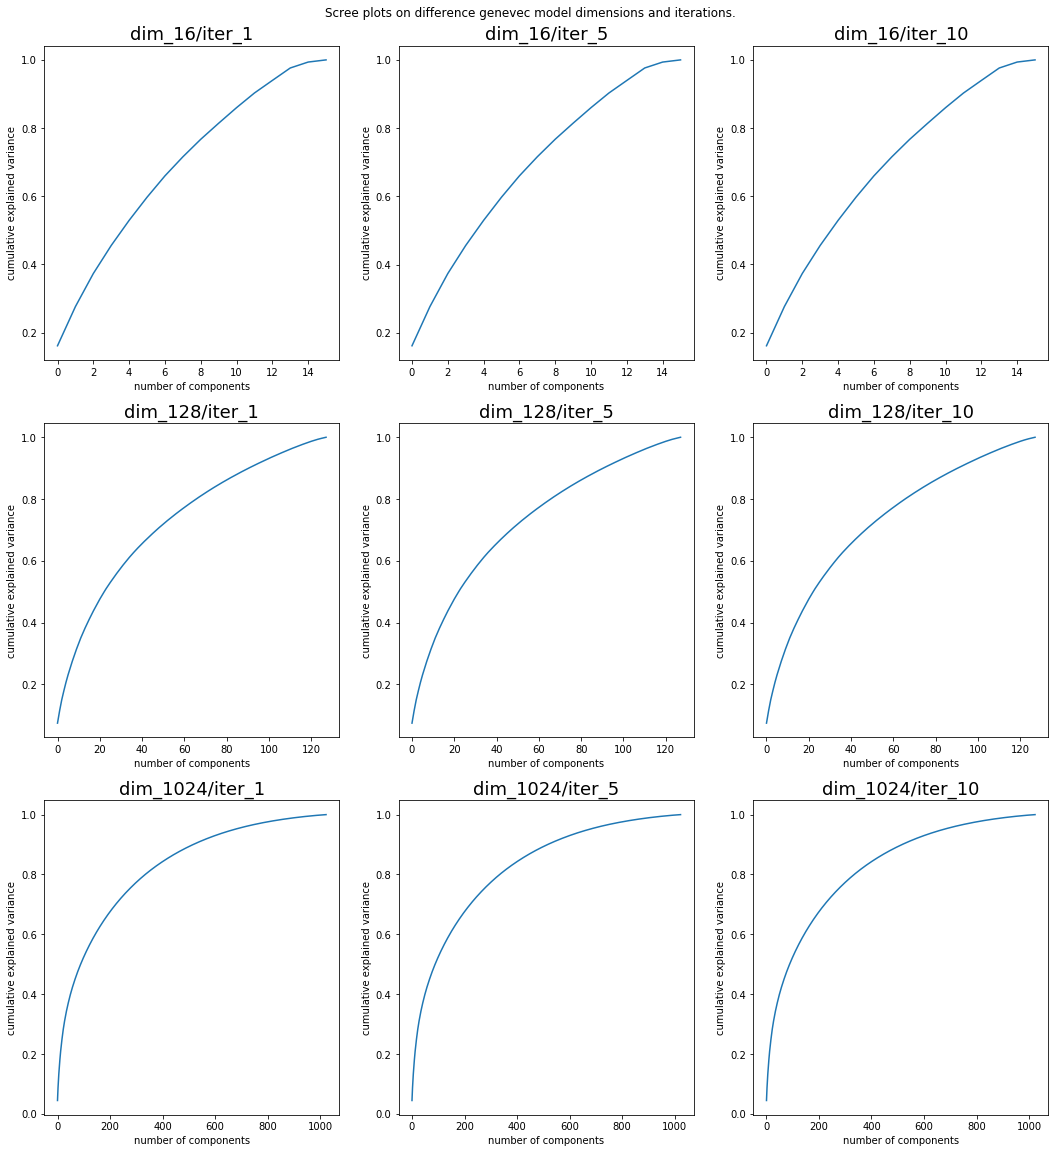

In [2]:
vis_pca2_genevec()
vis_scree_genevec()

---
#### Clustering Evaluation
<a id="cluster"></a>

Would like to audit available clustering techniques and visualise PCA2 to establish best technique to cluster/order genes. Clustering algorithms are taken from SKLearn and those available to be evaluated are:
- MiniBatchKMeans
- SpectralClustering
- Ward
- DBSCAN
- OPTICS
- Birch
- GaussianMixture

To do:
- Add non-linear kernel PCA
- tSNE on PCA
- Compare with VAE latent space
- [Beta TC-VAE](https://arxiv.org/pdf/1802.04942.pdf)
- [Glow VAE](https://openai.com/blog/glow/)

CPU times: user 17min 26s, sys: 15.5 s, total: 17min 42s
Wall time: 4min 3s


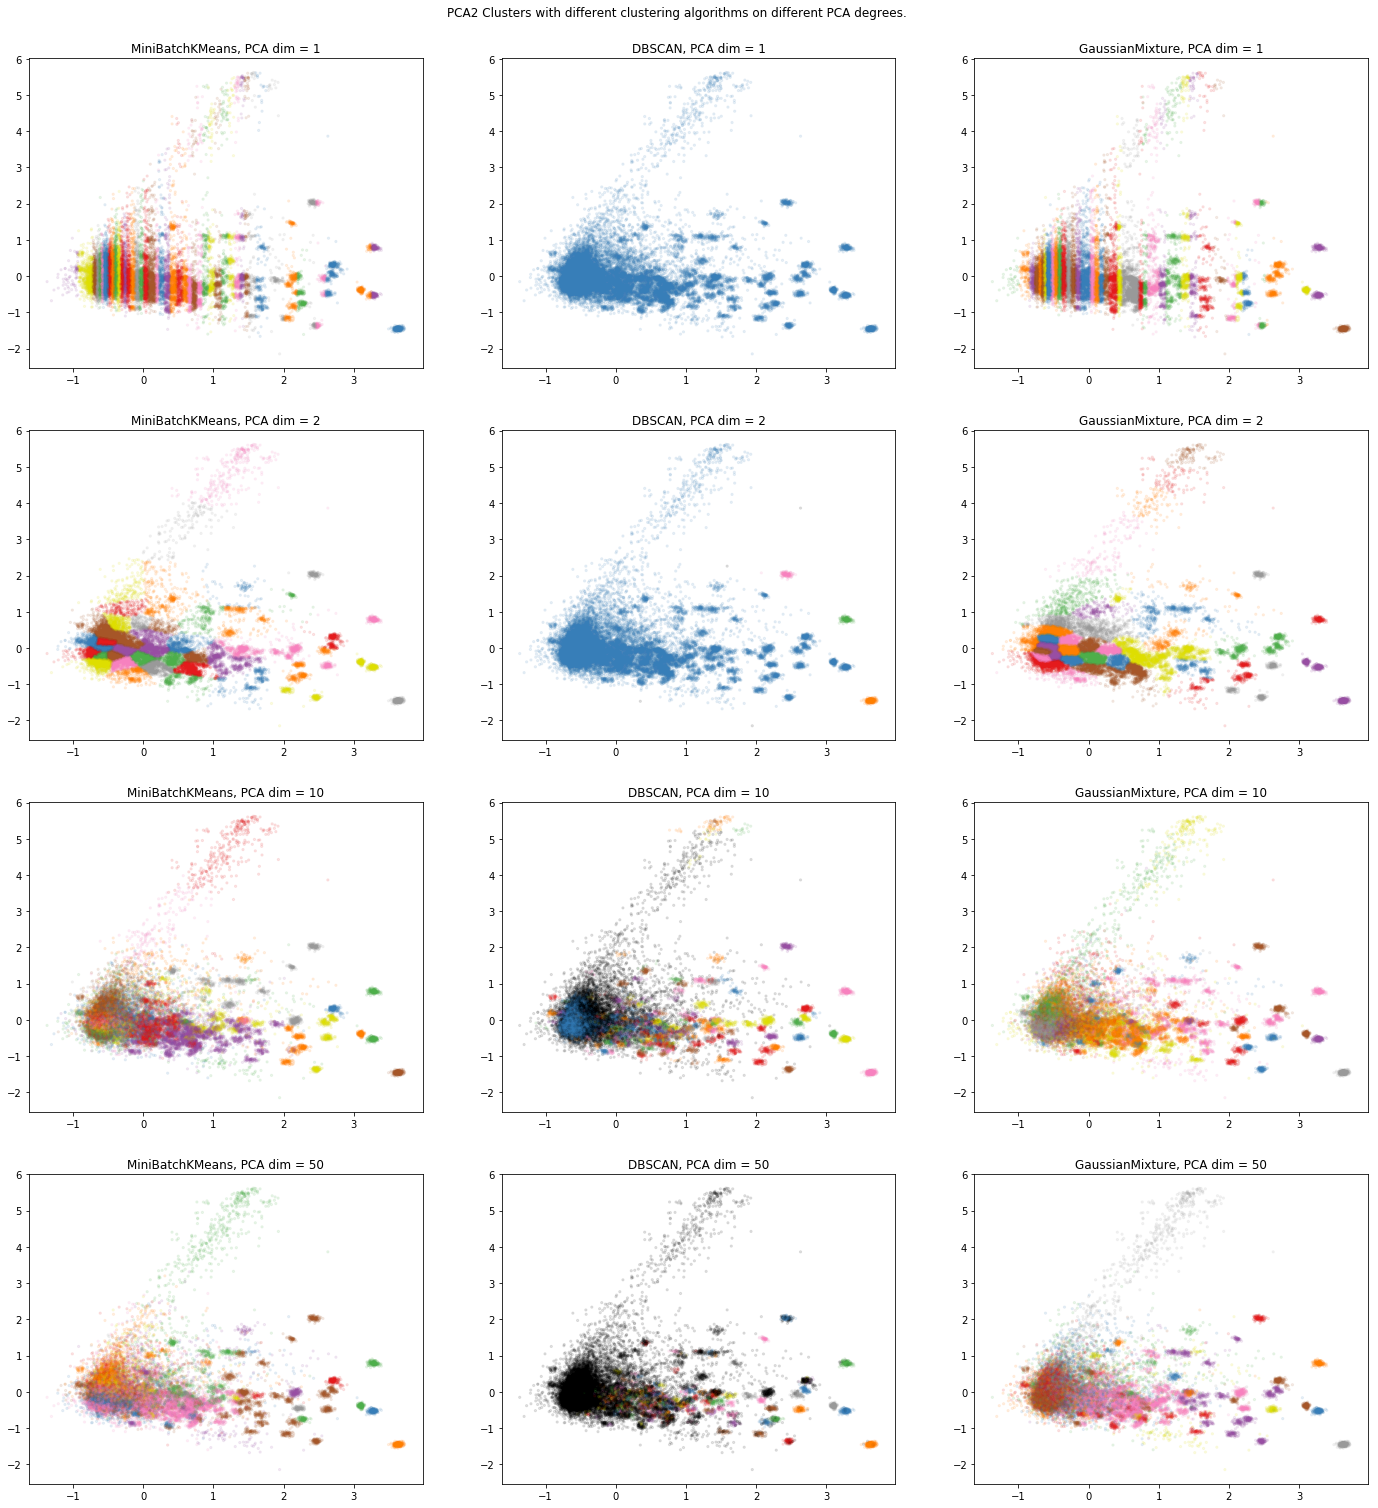

In [3]:
%%time
# load data
dim = 256
filename = str(GENE2VEC / 'dim_{}/iter_10'.format(dim))
wv, vocab = load_embeddings(filename)
X = wv
    
pca_degree=[1, 2, 10, 50]
selected_algos = ['MiniBatchKMeans',
                  'DBSCAN',
                  'GaussianMixture']
vis_pca2_clusters(X, pca_degree, selected_algos, n_clusters=50)

---
#### Load and preprocess somatic mutations from [TCGA in BigQuery](https://bigquery.cloud.google.com/table/isb-cgc:TCGA_hg38_data_v0.Somatic_Mutation?pli=1)
<a id="tcga"></a>

- Subset query has already been completed in BQ and saved to Google Cloud Storage
- In absence of MutSigCV results use list of 459 driver genes from [Intogen](https://www.intogen.org/search)

In [ ]:
# raw data
tcga_raw = pd.read_csv(TCGA)

# empirical dim reduction
df_proc1 = (tcga_raw.pipe(process_labels)
                    .pipe(filter_variants)
                    .pipe(filter_intogen_drivers))

# statistical dim reductions
df_proc2 = (tcga_raw.pipe(process_labels)
                    .pipe(filter_variants)
                    .pipe(drop_low_mut_count, 'Hugo_Symbol', 200))     # naïvely remove very genes with few mutations as noise

# visualise_distributions(tcga_raw, 'Raw TCGA Data')
# visualise_distributions(df_proc1, 'Empirical Dim Reduction')
# visualise_distributions(df_proc2, 'Statistical Dim Reduction')

# Get processed dataframes ready for training
df_X1 = (df_proc1.pipe(dedup_and_get_variant_count)
                 .pipe(reshape_pivot))

df_X2 = (df_proc2.pipe(dedup_and_get_variant_count)
                 .pipe(reshape_pivot))

df_y1 = (df_proc1.pipe(get_label_df, df_X1))
df_y2 = (df_proc2.pipe(get_label_df, df_X2))

del df_proc1, df_proc2
freememory()

---
#### Visualise Clustering on subset of filtered genes
<a id="subset"></a>

- DF_X1 is 'empirical' gene selection using intogen list
- DF_X2 is 'statistical' gene selection

In [ ]:
df_somatic = convert_to_onehot(df_X1)
df_genevec = pd.DataFrame(wv.transpose(), columns=vocab)
genes = gene_intersection(df_somatic, df_genevec)
merge1 = df_somatic[genes]
merge2 = df_genevec[genes]

pca_degree=[1, 2, 10, 50, 100]
selected_algos = ['MiniBatchKMeans',
                  'Ward',
                  'Birch',
                  'GaussianMixture']
# vis_pca2_clusters(merge2.values.transpose(), pca_degree, selected_algos, alpha=1, n_clusters=10)

In [ ]:
test = convert_to_onehot(df_X2)
df_genevec = pd.DataFrame(wv.transpose(), columns=vocab)
genes = gene_intersection(test, df_genevec)
merge1 = test[genes]
merge2 = df_genevec[genes]

pca_degree=[1, 2, 10, 50, 100]
selected_algos = ['MiniBatchKMeans',
                  'Ward',
                  'Birch',
                  'GaussianMixture']
# vis_pca2_clusters(merge2.values.transpose(), pca_degree, selected_algos, alpha=1, n_clusters=10)

---
#### Image Evaluation
<a id="image"></a>

Visual comparison of resulting images for a particular sample. Looking at different parameter combinations.
Explore following parameters on images:
- Clustering algorithm for sorting 
    - {GaussianMixture, DBScan, 1D-PCA} vs dimensionality of GeneVectors {64, 256, 512}
    - [Spectral Biclustering](https://scikit-learn.org/stable/auto_examples/bicluster/plot_spectral_biclustering.html#sphx-glr-auto-examples-bicluster-plot-spectral-biclustering-py) or [Spectral Coclustering](https://scikit-learn.org/stable/auto_examples/bicluster/plot_spectral_coclustering.html#sphx-glr-auto-examples-bicluster-plot-spectral-coclustering-py)
- Normalisation on image matrix, resulting distribution on images and images themselves
    - 0,1 normalise on non-zero values only
    - Take absolute value only
- [Colour map](https://matplotlib.org/examples/color/colormaps_reference.html)
    - Favour best visual artefacts
    - For values symmetric around zero, use diverging colour map
    - Otherwise use perceptually uniform sequential colour map

In [ ]:
dims=[16, 32, 128, 512]
clustering_algos = ['MiniBatchKMeans',
                    'DBSCAN',
                    'GaussianMixture']

genes = gene_intersection(convert_to_onehot(df_X1), 
                          pd.DataFrame(wv.transpose(), columns=vocab))

vis_clustered_images(genes, dims, clustering_algos, n_clusters=50)

#### Clustering in both dimensions (vector dimesnion and genes)

In [ ]:
from cluster import *

dims=[16, 32, 128, 512]
clustering_algos = ['MiniBatchKMeans',
                    'Ward',
                    'Birch',
                    'SpectralClustering']

genes = gene_intersection(convert_to_onehot(df_X1),
                          pd.DataFrame(wv.transpose(), columns=vocab))

vis_clustered_2d(genes, clustering_algos, clusters=[1,2,5,50])

---

In [ ]:
colours = ['viridis','magma','gray','seismic']
norms = ['none','non-zero','abs value']

# load data
filename = GENE2VEC_DIR + 'dim_{}/iter_10'.format(128)
wv, vocab = load_embeddings(filename)

# get gene subset
df_genevec = pd.DataFrame(wv.transpose(), columns=vocab)
df_somatic = convert_to_onehot(df_X1)

genes = gene_intersection(df_somatic, df_genevec)

# initialise algos on gene subset
X = df_genevec[genes].values.transpose()

# y_preds1
algos = init_algos(X.transpose())
algos = tuple([algo for algo in algos if algo[0] in ['MiniBatchKMeans']])
y_preds = Parallel()(delayed(cluster_job)((name, algo, X.transpose())) for name, algo in algos)
y_pred1 = y_preds[0]

# y_preds2
algos = init_algos(X)
algos = tuple([algo for algo in algos if algo[0] in ['MiniBatchKMeans']])
y_preds = Parallel()(delayed(cluster_job)((name, algo, X)) for name, algo in algos)
y_pred2 = y_preds[0]

vis_image_norm_colours(df_genevec[genes], df_somatic[genes], y_pred1, y_pred2, norms, colours)

#### Experiments
- Visualise distribution of values in sample

In [ ]:
vis_norm_histogram(df_genevec[genes], df_somatic[genes], y_pred1, norms)

---

### Saving Cross Sections of Interest

In [ ]:
from cluster import generate_imageset
from dataset import generate_dataset

In [ ]:
dims = [32, 128]
clustering = ['MiniBatchKMeans']
colours = ['viridis']
norms = ['non-zero']

# load somatic mutations
tcga_raw = pd.read_csv(TCGA)
df_X0 = (tcga_raw.pipe(process_labels)
                 .pipe(filter_variants)
                 .pipe(filter_intogen_drivers)
                 .pipe(dedup_and_get_variant_count)
                 .pipe(reshape_pivot))
df_y0 = (tcga_raw.pipe(process_labels)
                 .pipe(filter_variants)
                 .pipe(filter_intogen_drivers)
                 .pipe(get_label_df, df_X0))
df_y = df_y0
df_somatic = convert_to_onehot(df_X0)

for dim in dims:
    # load gene vectors
    filename = GENE2VEC_DIR + 'dim_{}/iter_10'.format(dim)
    wv, vocab = load_embeddings(filename)
    df_genevec = pd.DataFrame(wv.transpose(), columns=vocab)
    genes = gene_intersection(df_somatic, df_genevec)
    X = df_genevec[genes].values.transpose()
    
    # get clusters in parallel from algos
    algos = init_algos(X.transpose())
    algos = tuple([algo for algo in algos if algo[0] in clustering])
    clusters1 = Parallel()(delayed(cluster_job)((name, algo, X.transpose())) for name, algo in algos)
    
    # get clusters in parallel from algos
    algos = init_algos(X)
    algos = tuple([algo for algo in algos if algo[0] in clustering])
    clusters2 = Parallel()(delayed(cluster_job)((name, algo, X)) for name, algo in algos)
    
    for i, alg in enumerate(clustering):
        # create df_X and df_y
        cluster1 = clusters1[i]
        cluster2 = clusters2[i]
        for norm in norms:
            df_X = generate_imageset(df_genevec[genes], df_somatic[genes], cluster1, cluster2, norm)    
        
            for colour in colours:
                # choose data dir
                data_dir = "../data/genevec_images/2d_clustering/dim={}_alg={}_norm={}_col={}".format(dim, alg, norm, colour)
                
                # generate dataset
                generate_dataset(df_X, df_y, data_dir, colour=colour)